In [57]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.dates as dates
import obspy
import obspy.signal.trigger as trigger
from hydrophone_data_processing import load, useful_variables, plotting, signal_processing
import event_detector_pipeline as edp

hydrophone_metadata = {
    'h1':{
        # start and end identifies the start time of the swarm where the amplitude magnitude is the highest
        'start':obspy.UTCDateTime('2019-05-21T07:35:00Z')
        ,'end':obspy.UTCDateTime('2019-5-21T07:48:00Z')
       # obspy_idx is the index within the stream for this data (all data is sorted from top to bottom of the borehole this way in lists)
        ,'obspy_idx':0
        # depth of the hydrophone
        ,'depth':30
        ,'velocity_model':1750
    }
    ,    'h2':{
        'start':obspy.UTCDateTime('2019-05-21T07:35:00Z')
        ,'end':obspy.UTCDateTime('2019-5-21T07:48:00Z')
        ,'obspy_idx':1
        ,'depth':100        
        ,'velocity_model':1750

    }
    ,    'h3':{
        'start':obspy.UTCDateTime('2019-05-21T07:35:00Z')
        ,'end':obspy.UTCDateTime('2019-5-21T07:48:00Z')
        ,'obspy_idx':2
        ,'depth':170        
        ,'velocity_model':1750

    }
    ,'h4':{
        'start':obspy.UTCDateTime('2019-05-21T07:48:00Z')
        ,'end':obspy.UTCDateTime('2019-5-21T08:07:00Z')
        ,'obspy_idx':3
        ,'depth':240
        ,'velocity_model':1750
    }
    ,'h5':{
        'start':obspy.UTCDateTime('2019-05-21T08:07:00Z')
        # ,'end':obspy.UTCDateTime('2019-5-21T08:34:00Z')
        ,'end':obspy.UTCDateTime('2019-5-21T08:38:00Z')
        ,'obspy_idx':4
        ,'depth':310
        ,'velocity_model':1750
    }
    ,'h6':{
        'start':obspy.UTCDateTime('2019-05-21T08:34:00Z')
        ,'end':obspy.UTCDateTime('2019-5-21T08:38:00Z')
       ,'obspy_idx':5
        ,'depth':380
        ,'velocity_model':1750
    }
}

In [2]:
df = pd.read_csv('precision.csv')

In [3]:
paths = useful_variables.make_hydrophone_data_paths(borehole='a', year=2019, julian_day=141)
waveforms = load.import_corrected_data_for_single_day(paths=paths)
swarm_starttime = obspy.UTCDateTime('2019-05-21T07:30:00')
swarm_endtime = obspy.UTCDateTime('2019-05-21T08:38:30')
waveforms = waveforms.trim(starttime=swarm_starttime, endtime=swarm_endtime)

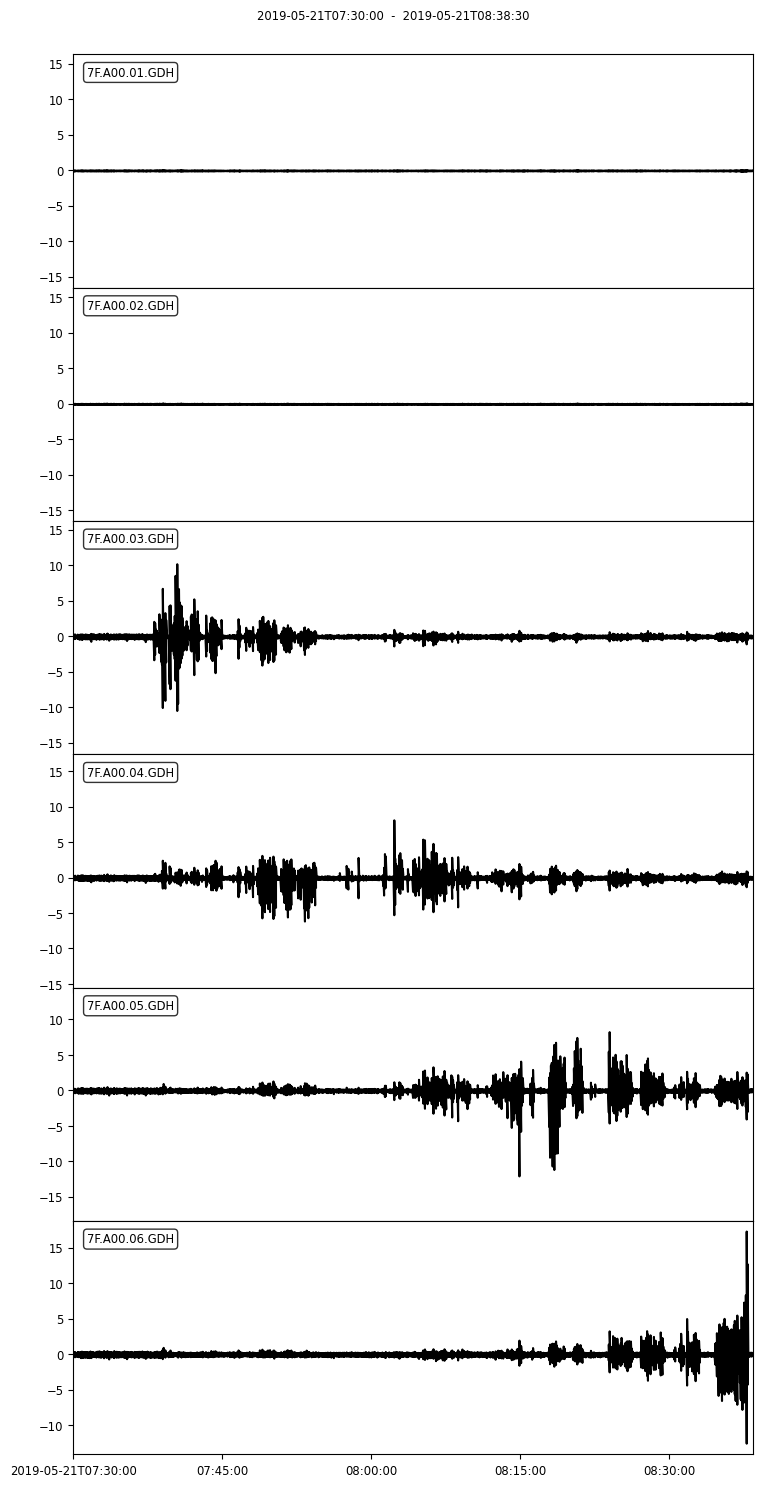

In [4]:
# x = waveforms.plot()


In [5]:
# waveforms.filter(type='highpass', freq=100, zerophase=False, corners=1)

In [6]:
# x = waveforms.plot()

/home/john/anaconda3/envs/borehole/lib/python3.8/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (500) of bandpass is at or above Nyquist (500.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/john/anaconda3/envs/borehole/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/john/anaconda3/envs/borehole/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/john/anaconda3/envs/borehole/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3757: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/john/anaconda3/envs/borehole/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrm

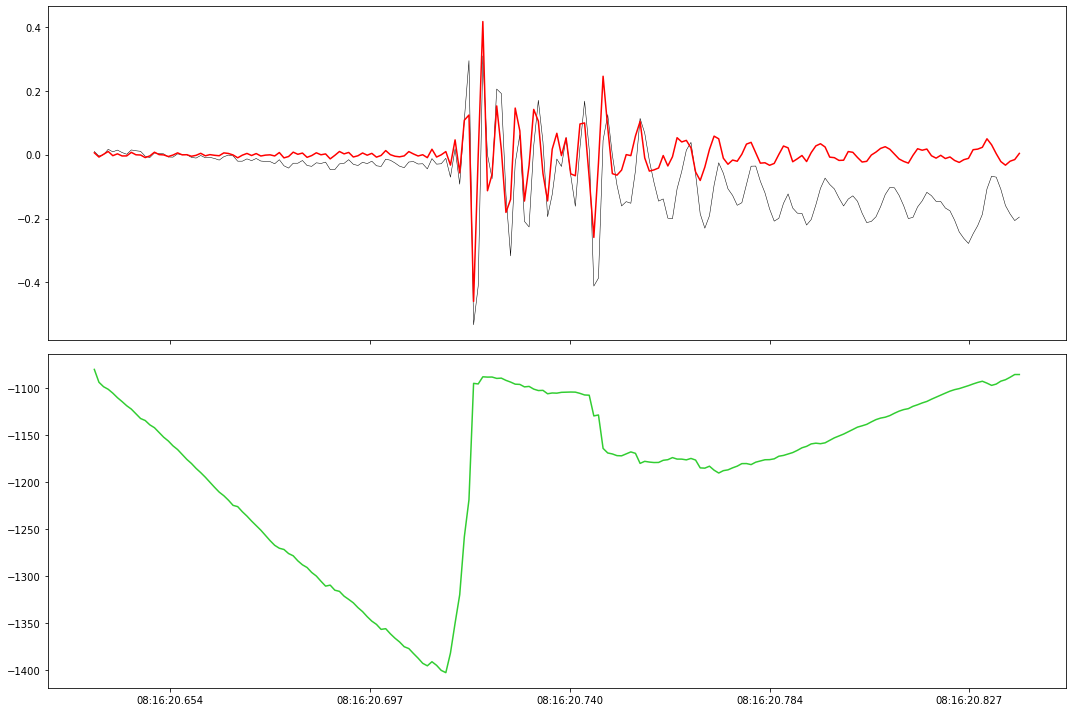

In [114]:
# event = df.iloc[750]
event = df.iloc[1200]
starttime = obspy.UTCDateTime(pd.to_datetime(event.first_arrival))

window_start = starttime - 0.05
window_end = starttime + 0.15

window = waveforms.copy().trim(starttime=window_start, endtime=window_end)
raw = window.copy()
# window.filter(type='highpass', freq=450, zerophase=False, corners=1)
window.filter(type='bandpass', freqmin=200, freqmax=500, zerophase=False, corners=1)

# fig, ax = plt.subplots(4, 1, figsize=(15, 15), sharey=True, sharex=True)
# fig, ax = plt.subplots(2, 1, figsize=(15, 10), sharey=True, sharex=True)
fig, ax = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# ax.plot((starttime, starttime), (-2, 2))

for n, tr in enumerate(raw[3:]):
    # ax[n].plot(tr.times('matplotlib'), tr.data, color='black', linewidth=0.5)
    ax[n].plot(tr.times('matplotlib'), tr.data, color='black', linewidth=0.5)
    break

for n, tr in enumerate(window[3:]):
    # ax[n].plot(tr.times('matplotlib'), tr.data, color='red', linewidth=0.5)
    ax[n].plot(tr.times('matplotlib'), tr.data, color='red', linewidth=1.5)
    break

aic = trigger.aic_simple(window[3].data)

# ax[1].plot(window[3].times('matplotlib'), aic)

data = tr.data
times = tr.times('matplotlib')

minus_means = []
minus_vars = []
plus_means = []
plus_vars = []

for n, t in enumerate(times):
    window_minus = data[0:n]
    window_plus = data[n:]
    
    # minus_mean = np.mean(window_minus)
    # minus_var = np.var(window_minus)
    
    # plus_mean = np.mean(window_plus)
    # plus_var = np.var(window_plus)
    
    minus_means.append(np.mean(window_minus))
    minus_vars.append(np.var(window_minus))
    plus_means.append(np.mean(window_plus))
    plus_vars.append(np.var(window_plus))
    
# minus_means = np.array(minus_means)
minus_vars = np.array(minus_vars)
# plus_means = np.array(plus_means)
plus_vars = np.array(plus_vars)

plus_vars = np.nan_to_num(plus_vars, nan=0.0)
minus_vars = np.nan_to_num(minus_vars, nan=0.0)

# h, e = np.histogram(plus_vars, bins=100)
# plus_geq = e[25]
# plus_vars[plus_vars <= plus_geq] = 0

# h, e = np.histogram(minus_vars, bins=100)
# minus_geq = e[25]
# minus_vars[minus_vars <= minus_geq] = 0

# mean_ratio = plus_means/minus_means
# var_ratio = plus_vars/minus_vars
# var_ratio = (plus_vars/plus_vars.max())/(minus_vars/minus_vars.max())
var_ratio = (plus_vars - minus_vars)/(plus_vars + minus_vars)

# ax[1].plot(tr.times('matplotlib'), mean_ratio)
# ax[1].plot(tr.times('matplotlib'), var_ratio, color='limegreen')
ax[1].plot(tr.times('matplotlib'), aic, color='limegreen')

# max_t = np.argmax(var_ratio)
# ax[1].plot((tr.times('matplotlib')[max_t],), (np.max(var_ratio),), marker='^')
    

ax[1].xaxis.set_major_formatter(plotting.PrecisionDateFormatter("%H:%M:%S.{ms}"))

fig.tight_layout()

## fig, ax = plt.subplots()

ax.plot(tr.times(), plus_vars, color='red')
ax.plot(tr.times(), minus_vars, color='green')

ax2 = ax.twinx()
ax2.plot(tr.times(), tr.data/tr.data.max(), color='black', linewidth=0.5)

6 Trace(s) in Stream:
7F.A00.01.GDH | 2019-05-21T08:09:08.009000Z - 2019-05-21T08:09:08.209000Z | 1000.0 Hz, 201 samples
7F.A00.02.GDH | 2019-05-21T08:09:08.009000Z - 2019-05-21T08:09:08.209000Z | 1000.0 Hz, 201 samples
7F.A00.03.GDH | 2019-05-21T08:09:08.009000Z - 2019-05-21T08:09:08.209000Z | 1000.0 Hz, 201 samples
7F.A00.04.GDH | 2019-05-21T08:09:08.009000Z - 2019-05-21T08:09:08.209000Z | 1000.0 Hz, 201 samples
7F.A00.05.GDH | 2019-05-21T08:09:08.009000Z - 2019-05-21T08:09:08.209000Z | 1000.0 Hz, 201 samples
7F.A00.06.GDH | 2019-05-21T08:09:08.009000Z - 2019-05-21T08:09:08.209000Z | 1000.0 Hz, 201 samples